# <span style="color:orange"> *Multiple bounded optimization* </span> 

In [5]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import subprocess
import sys
import pandas as pd
import os

 # <span style="color:lime"> *Repository & Tool loading* </span> 

In [2]:
%cd susceptibility-to-fieldmap-fft 
!git status
%pip install .

[WinError 2] The system cannot find the file specified: 'susceptibility-to-fieldmap-fft'
c:\Users\User\msc_project\sus-optimization\susceptibility-to-fieldmap-fft


c:\Users\User\miniconda3\envs\chi_opt\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


HEAD detached at d9f785b
nothing to commit, working tree clean
Processing c:\users\user\msc_project\sus-optimization\susceptibility-to-fieldmap-fft
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for susceptibility-to-fieldmap-fft: filename=susceptibility_to_fieldmap_fft-0.0.0-py3-none-any.whl size=23545 sha256=00da8cd86cf11cfd6760852e7fbc46c016f4630f7dc1ce1ec201040e6fc1dc46
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\17\ea\51\22427b7b5d1aced006c3db69245d8a8f88effcb4349a030d61
Successfully built susceptibility-to-fieldmap-fft
  Attempting uninstall: susceptibility-to-fieldmap-fft
    Found existing installation: susceptibility-to-fieldmap-fft 0.0.0
    Uninstalling susceptibility-to-fieldmap-fft-0.0.0:
      Successfully uninstalled susceptibility-to-fieldmap-fft-0.0.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
home_path = "C:/Users/User/msc_project/sus-optimization"
#Once we confirmed the head of the chi to fbfest we can go to home
%cd {home_path}
!ls

C:\Users\User\msc_project\sus-optimization


c:\Users\User\miniconda3\envs\chi_opt\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


README.md
__pycache__
chi_opt_pro.ipynb
data
evas_code.ipynb
extract_metric.py
internal_air_only.nii.gz
output
requirements.txt
simulation
soothsayer.ipynb
spinal_cord_voxels_only.nii.gz
sus_optimization.ipynb
susceptibility-to-fieldmap-fft
tissue-to-MRproperty


In [6]:
path_to_chi_to_fm_fft = "C:/Users/User/msc_project/susceptibility-to-fieldmap-fft"
sys.path.append(path_to_chi_to_fm_fft)
#sys.path.append('/Users/evaalonsoortiz/Documents/python/susceptibility-to-fieldmap-fft/')
from functions import compute_fieldmap

## <span style="color:lime"> *Util functions used during the optimization process* </span> 

In [8]:
# We need to reate the custom command that creates the fieldmap
def chi_to_fm_ppm(input_file, output_file):

    #Using a custom command for dB0 simulation

    command = [
    "compute_fieldmap",
    "-i", input_file,
    "-o", output_file,
    "-b", "50",
    "-m", "b0SimISMRM"
    ]

    # Run the command and capture output
    result = subprocess.run(command, capture_output=True, text=True)

    # We need to return the data from the fieldmap created

    
    # Check for errors
    if result.returncode != 0:
        print("Error occurred:", result.stderr)

    else:
        print("Fieldmap simulated correctly", result.stdout)
        sim_fm_img = nib.load(output_file)
        sim_fm_data = sim_fm_img.get_fdata()
        return sim_fm_data

In [10]:
# Function to automate the subprocess of extractiing measure with SCT through the terminal
from utils.extract_metric import extract_metrics
# Example of calling the function:
#extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_metric_mask, out_B0_metrics_path, method='wa', vert="3:15") # Change numbers x:y accordingly

 # <span style="color:gold"> *Optimization begins!* </span> 

In [140]:
# First lets define the paths for simulation files
# Change run # to avoid mix of outputs per different optimization approach
path_to_iter_dmod_fms =  "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test"
path_to_iter_metrics =  "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test"
counter = 0

########
# This don't change
path_to_sim_metric_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz"
path_to_dmod_mask = "E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz"
path_to_chimap = "E:/msc_data/ismrm_2025/db0_032/fm/sim/B1_chi_maps/db0_032_sus_opt_map.nii.gz" # -4.36 (past value)
path_to_segs = "E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/grouped_wb_segs.nii.gz"

In [35]:
# Now load the measured values (done 1 time outside of loop, this values are the reference)
b0meas_metrics = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/C_dmod_meas/exp/exp_metrics.csv")
dmod_b0meas_vert_values = b0meas_metrics["WA()"]
dmod_b0meas_vert_values = dmod_b0meas_vert_values[::-1]
dmod_b0meas_vert_values

12   -133.966738
11   -121.118786
10    -80.314337
9      -8.943227
8      55.167182
7      39.844835
6     -12.995903
5      -8.459881
4      22.489457
3      56.544607
2      63.354887
1      41.714478
0      19.229226
Name: WA(), dtype: float64

In [114]:
avg_resp_b0meas_metrics_csv = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/C_dmod_meas/simple_avg_respiration.csv")
avg_resp_b0meas_values = avg_resp_b0meas_metrics_csv["WA()"]
avg_resp_b0meas_values

0    -120.366184
1    -100.056767
2     -42.013446
3      43.314191
4     104.134758
5      67.827829
6     -12.573064
7     -30.862036
8     -10.427612
9      17.335520
10     25.933529
11     15.269733
12     -3.524973
Name: WA(), dtype: float64

In [63]:
def f_max(x):

    global counter # This works?
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    ind_body = np.where((ROI_data == 2))
    ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    sim_chi_data[ind_trachea] = x[0]
    sim_chi_data[ind_lungs] = x[1]
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi1 = x[0]
    chi2 = x[1]
    #chi3 = x[2]

    chi1_name = str(str(float(f"{chi1:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi2:.3f}"))).replace(".","_")
    #chi3_name = str(str(float(f"{chi3:.3f}"))).replace(".","_")

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving ... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()']
    dmod_sim_vert_values = dmod_sim_vert_values[::-1]

    difference = np.linalg.norm(dmod_b0meas_vert_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    return difference
    


In [131]:
def f_max_avg_resp(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    ind_body = np.where((ROI_data == 2))
    ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    sim_chi_data[ind_trachea] = x[0]
    sim_chi_data[ind_lungs] = x[1]
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi1 = x[0]
    chi2 = x[1]
    #chi3 = x[2]

    chi1_name = str(str(float(f"{chi1:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi2:.3f}"))).replace(".","_")
    #chi3_name = str(str(float(f"{chi3:.3f}"))).replace(".","_")

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving ... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()']
    dmod_sim_vert_values = dmod_sim_vert_values[::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    return difference

In [152]:
def f_max_avg_resp_plot(x):

    global counter # This works? 
    
    counter += 1  
    print('################')
    print(f"Iteration #{counter}")
    print(f"Current values of variables: x[0] = {x[0]} & x[1] = {x[1]}")
    #print(f"Current values of variables: x[0] = {x[0]}, x[1] = {x[1]} & x[2] = {x[2]}")

    # Load the simulated susceptibility map in ppm
    sim_chi_img = nib.load(path_to_chimap)
    sim_chi_data = sim_chi_img.get_fdata()

    # Load segmentation labels that create the chimaps
    ROI_img = nib.load(path_to_segs)
    ROI_data = ROI_img.get_fdata()

    # Now we load the demodulation mask, which in this case is also the Spinal cord mask, can change
    dmod_mask_img = nib.load(path_to_dmod_mask)
    dmod_mask_data = dmod_mask_img.get_fdata()

    # Find indices with the labels we want to iterate!
    ind_trachea = np.where((ROI_data == 8))
    ind_lungs = np.where((ROI_data == 7))
    ind_body = np.where((ROI_data == 2))
    ind_bone = np.where((ROI_data == 3))
    
    # Assign variables 
    sim_chi_data[ind_trachea] = x[0]
    sim_chi_data[ind_lungs] = x[1]
    #sim_chi_data[ind_body] = x[2]
    #sim_chi_data[ind_bone] = x[3]

    # Now we gotta compute the B0 distribution in [ppm] using compute_bz from repository
    # Lets load the chi map with load_sus_dist from compute fieldmap to get the image res for FBFest
    chi_dist, image_res, affine_matrix = compute_fieldmap.load_sus_dist(path_to_chimap)

    sim_b0_ppm =  compute_fieldmap.compute_bz(sim_chi_data, image_resolution = image_res, buffer = 50,mode = "b0SimISMRM")
    # bz will be in [ppm] we go to Hz now
    sim_b0_Hz = sim_b0_ppm * 3 * 42.58 # deltaB0 [Hz] = dB0 [ppm] * 1e-6  * B0 [T] * 42.58* e6 [Hz/T] 

    # Chi[0] trachea and Chi[1] lung
    chi1 = x[0]
    chi2 = x[1]
    #chi3 = x[2]

    chi1_name = str(str(float(f"{chi1:.3f}"))).replace(".","_") # to take away the minus sign can use .strip("-")) at the end
    chi2_name = str(str(float(f"{chi2:.3f}"))).replace(".","_")
    #chi3_name = str(str(float(f"{chi3:.3f}"))).replace(".","_")

    dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.nii.gz" # First lets try 2, then 3 different for body with IMC prior
    #dmod_fm_name = f"dmod_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.nii.gz"
    path_to_dmod_fm = os.path.join(path_to_iter_dmod_fms, dmod_fm_name)

    # Now we need to demodulated the fieldmap 

    dmod_value = np.mean(sim_b0_Hz[dmod_mask_data == 1])
    print("Demod value for Simulation: ", dmod_value)
    dmod_sim_b0_Hz = sim_b0_Hz - dmod_value

    dmod_sim_b0_Hz_img = nib.Nifti1Image(dmod_sim_b0_Hz, affine = sim_chi_img.affine)
    nib.save(dmod_sim_b0_Hz_img, path_to_dmod_fm)
    print("Saving ... ", dmod_fm_name)

    # Now we extract metrics 
    metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_Hz.csv"
    #metrics_name = f"metrics_sim_fm_tr_{chi1_name}_l_{chi2_name}_bd_{chi3_name}_Hz.csv"
    path_to_out_metrics = os.path.join(path_to_iter_metrics,metrics_name)

    extract_metrics(path_to_dmod_fm, path_to_dmod_mask, path_to_sim_metric_mask, path_to_out_metrics, method='wa', vert="3:15")

    metric_values = pd.read_csv(path_to_out_metrics)
    dmod_sim_vert_values = metric_values['WA()'][::-1]

    difference = np.linalg.norm(avg_resp_b0meas_values - dmod_sim_vert_values )
    print("Minimizing difference: ", difference)

    vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8']

    plt.clf() # Clear the plot to only have 1 in the output
    plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = f"Run9 iter: {counter}", color = "#EF9A9A")  
    plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 
    plt.title(f"Sim vs Avg $\\chi$ tr: {chi1} & l: {chi2}")
    plt.xlabel('Vertebral Level', fontsize=12)
    plt.ylabel('B0 [Hz]', fontsize=12)
    plt.legend()

    yticks = range(-250, 101, 20) 
    plt.yticks(yticks)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.tight_layout()

# Show the plot
    plt.show()


    return difference

In [144]:
# Before running please verify your outpaths:
print(path_to_iter_dmod_fms)
print(path_to_iter_metrics)


E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test
E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test


In [153]:
# Reset counter if neceesary (alone verrsion)
# This should be done when defining new paths but sometimes can be overridden
# Use with care
counter = 0

################
Iteration #1
Current values of variables: x[0] = -2.5 & x[1] = 0.3
Demod value for Simulation:  -282.7281388952348
Saving ...  dmod_sim_fm_tr_-2_5_l_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test\dmod_sim_fm_tr_-2_5_l_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_5_l_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_5_l_0_3_Hz.csv


Minimizing difference:  407.8276849199664


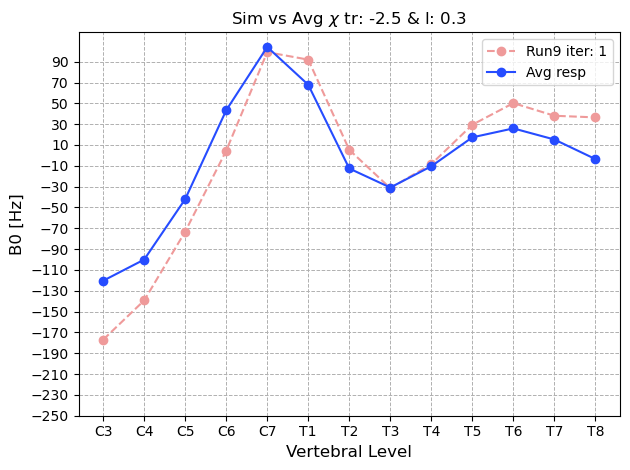

################
Iteration #2
Current values of variables: x[0] = -2.6 & x[1] = 0.3
Demod value for Simulation:  -282.7366535923719
Saving ...  dmod_sim_fm_tr_-2_6_l_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test\dmod_sim_fm_tr_-2_6_l_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_6_l_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_6_l_0_3_Hz.csv


Minimizing difference:  407.7743057227697


<Figure size 640x480 with 0 Axes>

################
Iteration #3
Current values of variables: x[0] = -2.5 & x[1] = 0.285
Demod value for Simulation:  -282.6892552214211
Saving ...  dmod_sim_fm_tr_-2_5_l_0_285_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test\dmod_sim_fm_tr_-2_5_l_0_285_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_5_l_0_285_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_5_l_0_285_Hz.csv


Minimizing difference:  407.92071859824597


<Figure size 640x480 with 0 Axes>

################
Iteration #4
Current values of variables: x[0] = -2.5999999999999996 & x[1] = 0.3
Demod value for Simulation:  -282.7366535923719
Saving ...  dmod_sim_fm_tr_-2_6_l_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test\dmod_sim_fm_tr_-2_6_l_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_6_l_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_6_l_0_3_Hz.csv


Minimizing difference:  407.77430572276967


<Figure size 640x480 with 0 Axes>

################
Iteration #5
Current values of variables: x[0] = -2.6 & x[1] = 0.3
Demod value for Simulation:  -282.7366535923719
Saving ...  dmod_sim_fm_tr_-2_6_l_0_3_Hz.nii.gz
Metrics extracted successfully: 
--
Spinal Cord Toolbox (6.2)

sct_extract_metric -i E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_fms/test\dmod_sim_fm_tr_-2_6_l_0_3_Hz.nii.gz -f E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask.nii.gz -method wa -vert 3:15 -vertfile E:/msc_data/ismrm_2025/db0_032/fm/sim/D2_D3_masks/cord_mask_labeled.nii.gz -perlevel 1 -o E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_6_l_0_3_Hz.csv
--


Load metric image...
Estimation for label: cord_mask

Done! To view results, type:
start E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/test\metrics_sim_fm_tr_-2_6_l_0_3_Hz.csv


Minimizing difference:  407.7743057227697


<Figure size 640x480 with 0 Axes>

################
Iteration #6
Current values of variables: x[0] = -2.6 & x[1] = 0.3


In [ ]:
# Set initial values, boundaries and run optimization
initial_values = [-2.5, 0.3] # Body should begin
# First bound is trachea
# Second bound is Lung
bounds = [(-2.6, -2), (-6, 0.3)]

if counter != 0 :
        # This means that you forgot to change the folder run number, to avoid mixing tests, please run that cell 
        # Changing the number after run!
    print("Please change run # to avoid mixing result folders :)")
else:
    if not os.path.exists(path_to_iter_dmod_fms) or not os.path.exists(path_to_iter_metrics):
        print("Creating run folders")
        os.makedirs(path_to_iter_dmod_fms)
        os.makedirs(path_to_iter_metrics)
        print("Folders created: ", path_to_iter_dmod_fms)
    
    result = optimize.minimize(f_max_avg_resp_plot, initial_values, bounds = bounds, method = 'Nelder-Mead')

    # Output the result
    print("Optimization result:", result)


In [89]:
os.path.exists(path_to_iter_dmod_fms)

True

# <span style="color:chocolate"> *Plot and compare!* </span> 

In [42]:
# Load specific metrics by name, from output log
run2_iter20 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-5_16_l_-0_389_Hz.csv")
run2_iter20_values = run2_iter20["WA()"]
run2_iter20_values = run2_iter20_values[::-1]

In [54]:
run4_last_iter = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run4/metrics_sim_fm_tr_-5_0_l_-0_575_Hz.csv")
run4_last_iter_vals = run4_last_iter["WA()"]
run4_last_iter_vals = run4_last_iter_vals[::-1]

In [70]:
# One with x lung far from that range
run6 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run6/metrics_sim_fm_tr_-2_0_l_1_0_Hz.csv")
run6_values = run6["WA()"][::-1]

In [106]:
run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7/metrics_sim_fm_tr_-2_0_l_0_0_Hz.csv")
run7_values = run7["WA()"][::-1]
run7_values

12   -179.632875
11   -142.424619
10    -76.976387
9      -0.345025
8      93.837069
7      89.462894
6       7.859834
5     -26.918593
4      -4.591906
3      32.335572
2      53.256685
1      41.671918
0      39.592175
Name: WA(), dtype: float64

In [107]:
first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")
first_run7_vals = first_run7["WA()"][::-1]
first_run7_vals

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\User\AppData\Local\Temp\ipykernel_49552\3367052066.py:1: SyntaxWarning: invalid escape sequence '\m'
  first_run7 = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run7\metrics_sim_fm_tr_-1_5_l_-4_36_Hz.csv")


12   -219.740118
11   -189.120055
10   -135.339877
9     -74.304475
8      13.790056
7      51.663695
6      43.468552
5      41.938307
4      59.908588
3      84.494172
2     100.697910
1      91.271720
0      81.204982
Name: WA(), dtype: float64

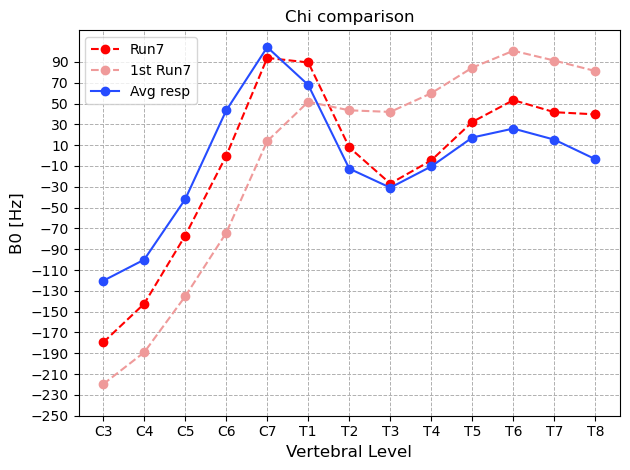

In [121]:
# We already have the cervical level and measured, 
# Copy the last (or any) fm metric name from SCT result

#final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics\metrics_sim_fm_tr_-14_0_l_-0_277_Hz.csv")
final_dmod = pd.read_csv("E:/msc_data/ismrm_2025/db0_032/fm/chi-opt/iteration_metrics/run2/metrics_sim_fm_tr_-9_0_l_-0_443_Hz.csv")

dmod_sim_vert_values = final_dmod["WA()"]
dmod_sim_vert_values = dmod_sim_vert_values[::-1]

vertebrae_levels = ['C3', 'C4', 'C5', 'C6', 'C7', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7','T8'] # From 3 to 15


#plt.plot(vertebrae_levels, dmod_b0meas_vert_values, marker = 'x', linestyle = '-', label = "Measured Exp", color = "#ff4900") 
#plt.plot(vertebrae_levels, dmod_sim_vert_values, marker = 'o', linestyle = '--', label = "Run1", color = "#33C3FF") 
#plt.plot(vertebrae_levels, run6_values, marker = 'o', linestyle = '--', label = "Run6", color = "#FBC02D") 
plt.plot(vertebrae_levels, run7_values, marker = 'o', linestyle = '--', label = "Run7", color = "red") 
plt.plot(vertebrae_levels, first_run7_vals, marker = 'o', linestyle = '--', label = "1st Run7", color = "#EF9A9A") 
#plt.plot(vertebrae_levels, run4_last_iter_vals, marker = 'o', linestyle = '--', label = "Run4", color = "#81C784") 
plt.plot(vertebrae_levels, avg_resp_b0meas_values, marker = 'o', linestyle = '-', label = "Avg resp", color = "#264cff") 

# Adding expiration and inspiration measured values
#plt.plot(vertebrae_levels, exp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Expiration B0 measured", color = "#ff4900")
#plt.plot(vertebrae_levels, insp_metrics_data_comp, marker = 'o', linestyle = '-', label = "Inspiration B0 measured", color = "#ffad00")
#plt.plot(vertebrae_levels, avg_respiration, marker = 'o', linestyle = ':', label = "Avg respiratin B0 meas", color = "#264cff")
plt.title("Chi comparison")
plt.xlabel('Vertebral Level', fontsize=12)
plt.ylabel('B0 [Hz]', fontsize=12)
plt.legend()

yticks = range(-250, 101, 20) 
plt.yticks(yticks)


# Customize grid and display
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()